In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import random
import tqdm

from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import layers
from doom_src import utilities
from collections import deque
from time import time
from vizdoom import *

First, let's load the config file and create a new game instance

In [3]:
config = utilities.get_config('configs/config.json')

In [4]:
game, actions = utilities.create_environment(config, visible=False)

We will now need a DQN model

In [5]:
class DQN_D():
    """
    Define the Deep-Q Network to play Doom.
    """
    
    def __init__(self, config):
        frame_size = config['frame_size']
        stack_size = config['stack_size']
        learning_rate = config['learning_rate']
        
        model = tf.keras.Sequential()
        
        # Convolutional layer 1
        model.add(
            layers.Convolution2D(
                filters=32, 
                kernel_size=(8, 8),
                strides=(4,4),
                padding='valid',
                input_shape=(frame_size, frame_size, stack_size),
            )
        )
        
        model.add(
            layers.BatchNormalization(
                epsilon = 1e-5,
            )
        )

#         # Convolutional layer 2
#         model.add(
#             layers.Convolution2D(
#                 filters=64, 
#                 kernel_size=(4, 4),
#                 strides=(2,2),
#                 padding='valid',
#             )
#         )
        
#         model.add(
#             layers.BatchNormalization(
#                 epsilon = 1e-5,
#             )
#         )
        
#         # Convolutional layer 3
#         model.add(
#             layers.Convolution2D(
#                 filters=64, 
#                 kernel_size=(4, 4),
#                 strides=(1,1),
#                 padding='valid',
#             )
#         )
        
#         model.add(
#             layers.BatchNormalization(
#                 epsilon = 1e-5,
#             )
#         )
    
        # Flatten before passing to dense layers
        model.add(layers.Flatten())
        
        # Dense layer 1
        model.add(
            layers.Dense(
                units=128,
                activation='relu',
            )
        )
        
        # Dense layer 2
        model.add(
            layers.Dense(
                units=3
            )
        )
        
        self.op = tf.keras.optimizers.Adam(lr=learning_rate)
        model.compile(loss='mse', optimizer=self.op)
        
        tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
        
        self.model = model
        self.board = tensorboard

In [6]:
def predict_action(policy_network, epsilon, state, actions):
    """
    Implements the epsilon-greedy strategy
    """
    
    if np.random.rand(1) < epsilon:
        max_Q = np.random.randint(len(actions))
    
    else:
        # print(state.shape)
        q = policy_network.model.predict(state.reshape([1,] + list(state.shape)))
        max_Q = np.argmax(q)
        # print(q, max_Q)
    
    action = actions[max_Q]
        
    return action, max_Q 

In [7]:
def train_net(config, n_episodes, game, actions):
    """
    Train the Q Network
    """
    
    gamma           = config['gamma']
    skip_rate       = config['skip_rate']
    stack_size      = config['stack_size']
    frame_size      = config['frame_size']
    pretrain_steps  = config['pretrain_steps']
    batch_size      = config['batch_size']
    memory_size     = config['memory_size']
#     annealing_steps = config['annealing_steps']
    annealing_steps = int(n_episodes * 0.8)
    update_freq = 20
    annealing_stop  = config['annealing_stop']
    annealing_start = config['annealing_start']
    
    n_actions = len(actions)
    
    episode_rewards = []
    episode_losses  = []
    episode_lengths = []
    
    # Initialize the DQN
    policy_net = DQN_D(config)
    target_net = DQN_D(config)
    
    # Inititalize the memory buffer
    memory = utilities.Memory(memory_size)
    
    # Initialize the linear annealing scheduler
    epsilon = utilities.LinearSchedule(
        annealing_steps, 
        annealing_stop, 
        annealing_start
    )
    
    # Inititalize the stack of frames
    stacked_frames = deque(
        [np.zeros((frame_size, frame_size), dtype=np.int) for i in range(stack_size)], 
        maxlen=stack_size
    ) 
    
    # Fill up the memory buffer
    utilities.pretrain(
        pretrain_steps,
        memory,
        stack_size,
        frame_size,
        stacked_frames,
        game,
        actions
    )
    print("Completed pretraining with memory size:", len(memory))
    
#     for episode in tqdm.tqdm(range(n_episodes)):
    for episode in range(n_episodes):        
        eps = epsilon.value(episode)
        episode_reward = 0.0
        episode_loss = 0.0
        episode_length = 0
        
        # New episode
        game.new_episode()
        done = game.is_episode_finished()
        
        # Initial state
        frame = game.get_state().screen_buffer
        state = utilities.stack_frames(
            stacked_frames, frame, True, stack_size, frame_size
        )
        
        while not done:
            # Action selection phase
            action, action_index = predict_action(policy_net, eps, state, actions)
#             print('action:', action_index, action)

#             reward = game.make_action(action, skip_rate)
            reward = game.make_action(action)
#             if reward > 0:
#                 print('killed the monster', reward)
#             print('reward:', reward)

            done = game.is_episode_finished()
#             print('done:', done)

            # Next state
            if done: # Dead
                frame = np.zeros(frame.shape)
            
            else:
                frame = game.get_state().screen_buffer
            
            next_state = utilities.stack_frames(
                stacked_frames, frame, False, stack_size, frame_size
            )
            
            memory.add((state, action_index, reward, next_state, done))
            episode_reward += reward
            
            # Learning step
            if episode_length % 4 == 0:
                batch = np.array(memory.sample(batch_size))

                state_b = np.stack(batch[:,0])
                action_b = np.stack(batch[:,1])  
                reward_b = np.stack(batch[:,2])
                next_state_b = np.stack(batch[:,3])
                done_b = np.stack(batch[:,4])

#                 print('state_b', state_b.shape)
#                 print('action_b', action_b.shape)
#                 print('action_b0', type(action_b[0]))
#                 print('reward_b', reward_b.shape)
#                 print('next_state_b', next_state_b.shape)
#                 print('done_b', done_b.shape)  

#                 print('state_b0', type(state_b[0]))
#                 print('action_b0', type(action_b[0]))
#                 print('reward_b0', type(reward_b[0]))
#                 print('next_state_b0', type(next_state_b[0]))
#                 print('done_b0', type(done_b[0]))
                
                
#                 Q_next_b = target_net.model.predict(next_state_b)
#                 targets_b = policy_net.model.predict(state_b)
                
#                 targets_b[range(batch_size), action_b] = reward_b + gamma * np.max(Q_next_b, axis=1) * np.invert(done_b)

                target = policy_net.model.predict(state_b)
                target_val = policy_net.model.predict(next_state_b)
                target_val_ = target_net.model.predict(next_state_b)

                for i in range(batch_size):
                    # like Q Learning, get maximum Q value at s'
                    # But from target model
                    if done_b[i]:
                        target[i][action_b[i]] = reward_b[i]
                    else:
                        # the key point of Double DQN
                        # selection of action is from model
                        # update is from target model
                        a = np.argmax(target_val[i])
                        target[i][action_b[i]] = reward_b[i] + gamma * (target_val_[i][a])

#                 episode_loss += policy_net.model.train_on_batch(state_b, targets_b)
                episode_loss += policy_net.model.train_on_batch(state_b, target)
            
            if episode_length % update_freq == 0:
                target_net.model.set_weights(policy_net.model.get_weights()) 

            episode_length += 1
        
        if episode % 10 == 0:
            policy_net.model.save('saved_models/DQN_mk3_policy.h5')
        
        episode_rewards.append(episode_reward)
        episode_losses.append(episode_loss)
        episode_lengths.append(episode_length)
    
    return episode_rewards, episode_losses, episode_lengths, policy_net

In [8]:
%%time
episode_rewards, episode_losses, episode_lengths, policy_net = train_net(config, 200, game, actions)

/Users/gio/.virtualenvs/doom/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Completed pretraining with memory size: 128
CPU times: user 55min 16s, sys: 11min 37s, total: 1h 6min 54s
Wall time: 13min 57s


In [9]:
game.close()

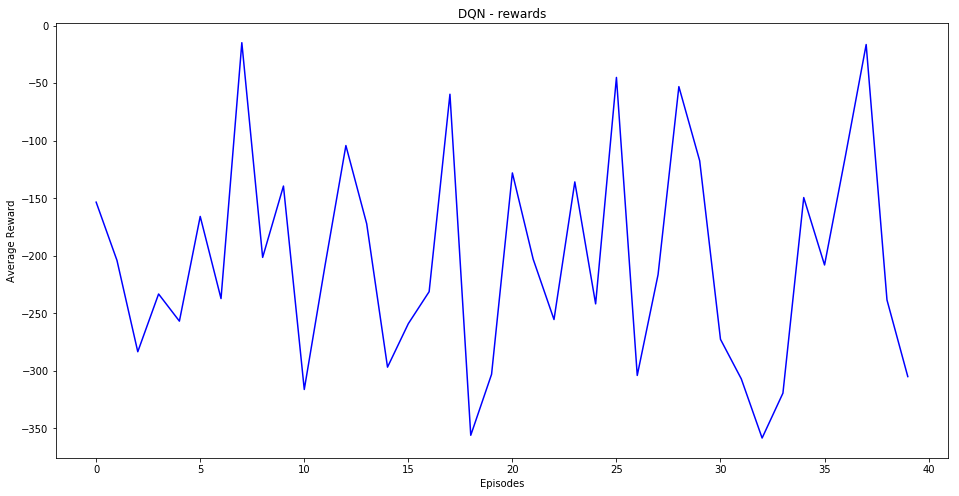

In [10]:
utilities.plot_reward_curve(episode_rewards, "DQN - rewards", 5)

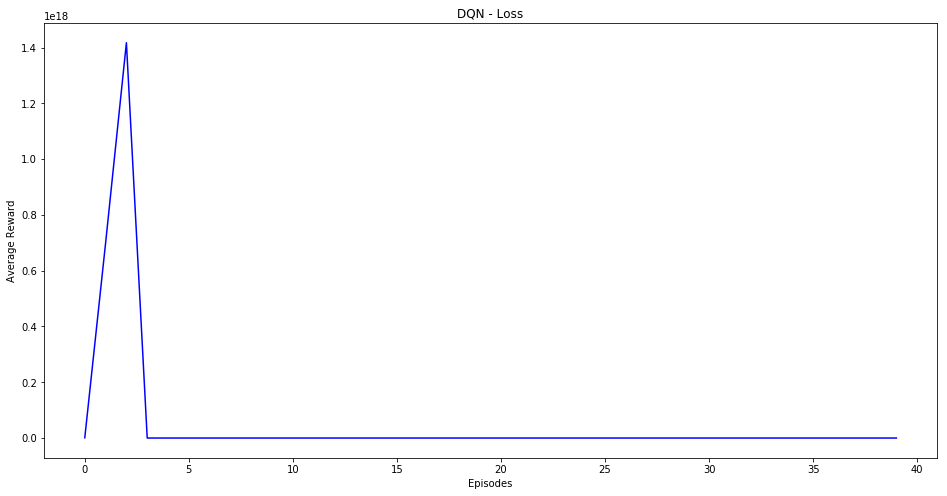

In [11]:
utilities.plot_reward_curve(episode_losses, "DQN - Loss", 5)

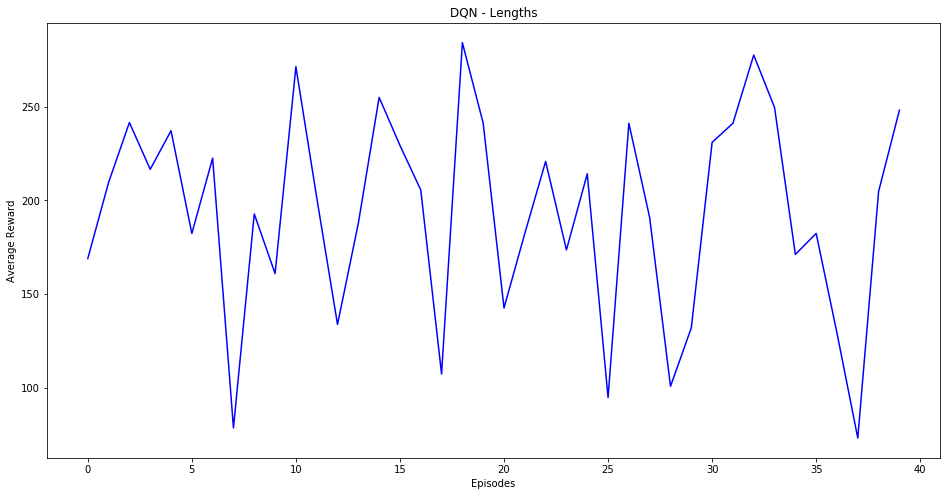

In [12]:
utilities.plot_reward_curve(episode_lengths, "DQN - Lengths", 5)